1.Unzipping the file

In [7]:
import zipfile

zip_path = "animals10.zip"   # file name
extract_path = "animals10"   # folder to extract into

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzip completed ✅")

Unzip completed ✅


In [9]:
#Check Unzip or not
import os
print(os.listdir("animals10"))

['raw-img', 'translate.py']


2.Split the Dataset

In [16]:
dataset_path = "animals10"

In [7]:
import os
import shutil
import random

dataset_path = "animals10/raw-img"

train_path = "animal_data/train"
val_path = "animal_data/val"

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

split_ratio = 0.8

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)

    if not os.path.isdir(class_dir):
        continue

    images = [img for img in os.listdir(class_dir)
              if img.lower().endswith((".jpg", ".jpeg", ".png"))]

    random.shuffle(images)

    split_index = int(len(images) * split_ratio)

    train_images = images[:split_index]
    val_images = images[split_index:]

    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_path, class_name), exist_ok=True)

    for img in train_images:
        shutil.copy(
            os.path.join(class_dir, img),
            os.path.join(train_path, class_name, img)
        )

    for img in val_images:
        shutil.copy(
            os.path.join(class_dir, img),
            os.path.join(val_path, class_name, img)
        )

print("Dataset split completed ✅")

Dataset split completed ✅


In [9]:
print(os.listdir("animal_data/train"))

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'raw-img', 'scoiattolo']


3.Load the data

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (160, 160)   # MobileNet works better with 160 or 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    "animal_data/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_data = val_datagen.flow_from_directory(
    "animal_data/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 25956 images belonging to 11 classes.
Found 12782 images belonging to 11 classes.


️4. Load Pretrained MobileNet (Without Top Layer)

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(160, 160, 3)
)

base_model.trainable = False   # First freeze

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dense(train_data.num_classes, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,371 (9.24 MB)

 Trainable params: 165,387 (646.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

5. Train the Transfer Learning Model

In [12]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 800s 969ms/step - accuracy: 0.7410 - loss: 0.8446 - val_accuracy: 0.9211 - val_loss: 0.2612
Epoch 2/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 796s 980ms/step - accuracy: 0.8670 - loss: 0.4248 - val_accuracy: 0.9297 - val_loss: 0.2287
Epoch 3/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 743s 915ms/step - accuracy: 0.8816 - loss: 0.3722 - val_accuracy: 0.9364 - val_loss: 0.2085
Epoch 4/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 685s 843ms/step - accuracy: 0.8913 - loss: 0.3420 - val_accuracy: 0.9375 - val_loss: 0.2022
Epoch 5/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 769s 947ms/step - accuracy: 0.8956 - loss: 0.3239 - val_accuracy: 0.9401 - val_loss: 0.1892
Epoch 6/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 827s 1s/step - accuracy: 0.9003 - loss: 0.3189 - val_accuracy: 0.9419 - val_loss: 0.1868
Epoch 7/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 824s 1s/step - accuracy: 0.9018 - loss: 0.3068 - val_accuracy: 0.9413 - val_loss: 0.1882
Epoch 8/10
812/812 ━━━━━━━━━━━━━━━━━━━━ 894s 1s/step - accuracy: 0.9051 - loss: 0.

7.Unfreez the top layers & Fine tuning

In [13]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # VERY IMPORTANT
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)

Epoch 1/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 500s 606ms/step - accuracy: 0.8755 - loss: 0.3839 - val_accuracy: 0.9470 - val_loss: 0.1688
Epoch 2/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 484s 597ms/step - accuracy: 0.8937 - loss: 0.3248 - val_accuracy: 0.9483 - val_loss: 0.1608
Epoch 3/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 606s 746ms/step - accuracy: 0.8998 - loss: 0.3029 - val_accuracy: 0.9515 - val_loss: 0.1533
Epoch 4/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 562s 692ms/step - accuracy: 0.9111 - loss: 0.2729 - val_accuracy: 0.9537 - val_loss: 0.1450
Epoch 5/5
812/812 ━━━━━━━━━━━━━━━━━━━━ 517s 637ms/step - accuracy: 0.9124 - loss: 0.2662 - val_accuracy: 0.9545 - val_loss: 0.1400


8.Visualization

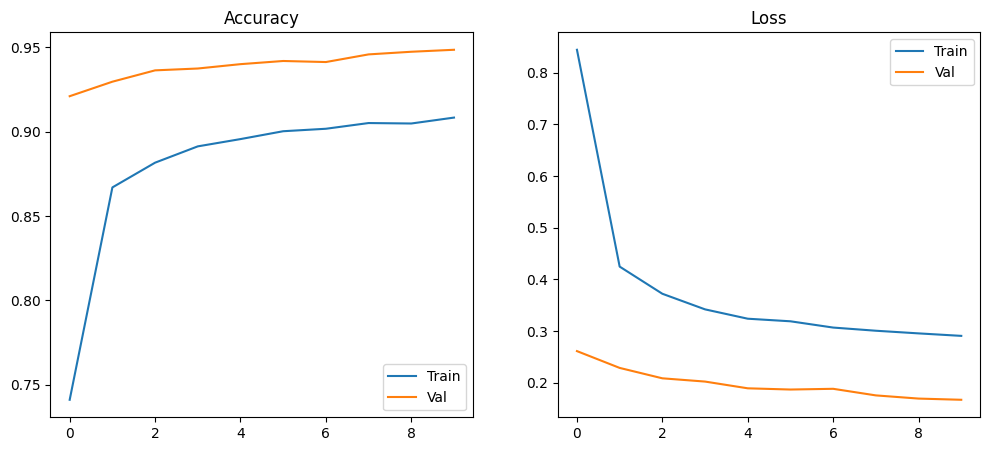

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(["Train","Val"])

plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.legend(["Train","Val"])

plt.show()

9.Create Class names

In [14]:
class_names = list(train_data.class_indices.keys())
print(class_names)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'raw-img', 'scoiattolo']


10.Image visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


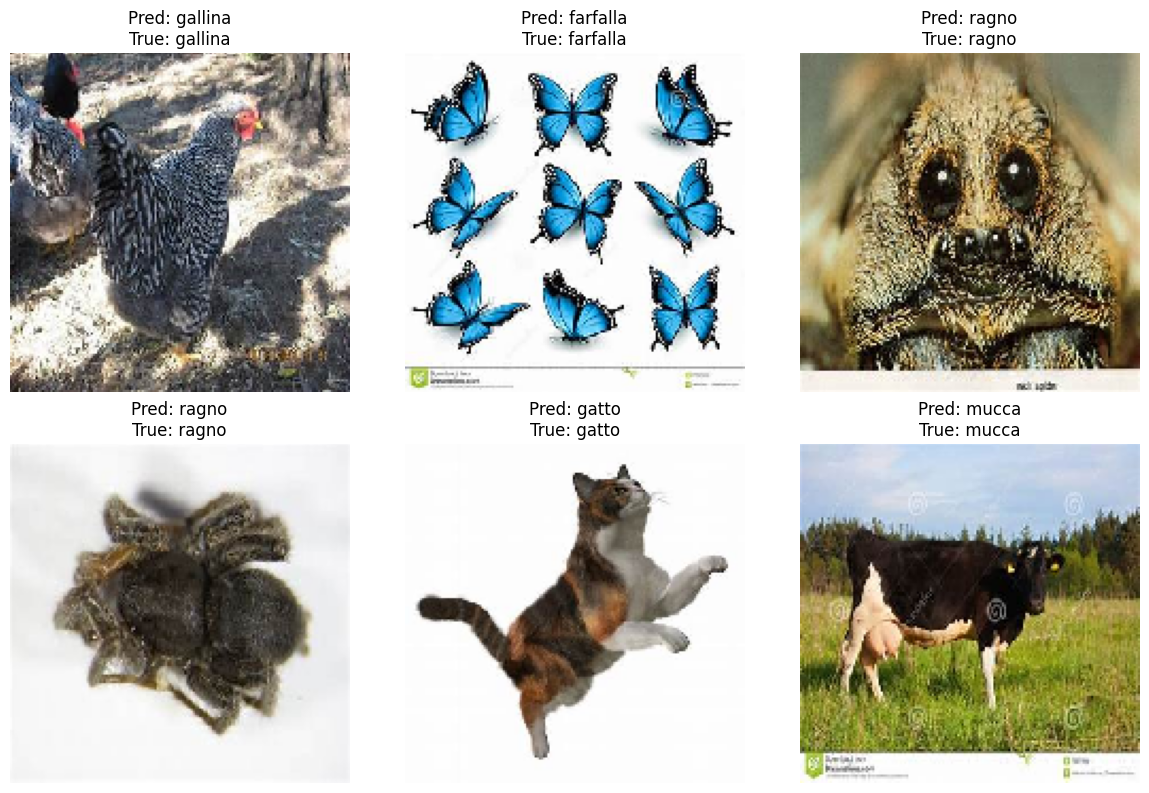

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch from validation set
images, labels = next(val_data)

# Predict
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

plt.figure(figsize=(12,8))

for i in range(6):   # show 6 images
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    
    pred_label = class_names[predicted_classes[i]]
    true_label = class_names[np.argmax(labels[i])]
    
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]
